In [54]:
from IPython.display import display

from tqdm import tqdm
from pathlib import Path
import time
import json

#from pysr import PySRRegressor

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import simple_harmonic_oscillator as sho

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(42)

In [55]:
checkpoint_dir = Path("checkpoints") / f"vae_{time.strftime('%Y%m%d-%H%M%S')}"
checkpoint_dir.mkdir(parents=True, exist_ok=False)

config = {
	'epochs': 10,
	'pretrain_epochs': 50,
	'lr': 1e-2,
	'batch_size': 16,
	'kl_weight': 0.1,
	'pretrain_kl_weight': 0.01,
	'aa_weight': 0.05,
	'dim': 1,
	'n': 100, # how many samples per trajectory
	'dt': 0.1 # time difference between samples
}

### Possible Initial Conditions

True

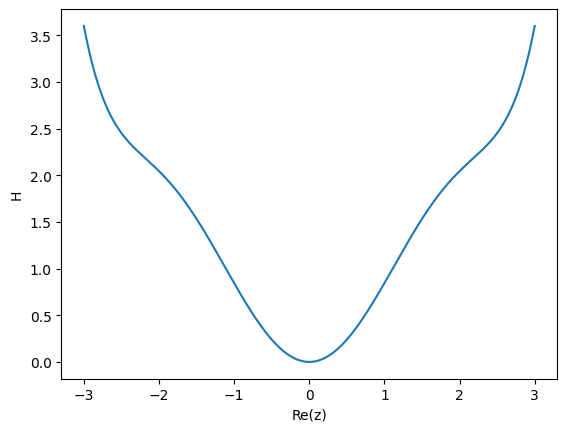

In [56]:
omega0_val = 1
h_f, dhdx_bar_f, xp_f = sho.hamiltonian_system()

z = np.linspace(-3, 3, 1000)
plt.plot(z, h_f(z + 0j, z - 0j, 1).real)
plt.xlabel("Re(z)")
plt.ylabel("H")

# Set initial condition for x and x̄ based on chosen 
# energy H as sqrt(H/omega_0) with phase as 0
desired_h = 2
x0 = sho.solve_for_x(h_f, desired_h, omega0_val)

np.allclose(2, h_f(x0, x0, omega0_val))

In [25]:
hamiltonians = np.linspace(0.1, 1.5, 1000)
num_random_starts = 10
random_start_range = (0, 10)
trajectory_duration = config['n'] * config['dt']

# Train Data
train_dset = []
for h_val in hamiltonians:
	x0 = sho.solve_for_x(h_f, h_val, omega0_val)
	random_starts = torch.randint(*random_start_range, (num_random_starts,))
	for tstart in random_starts:
		t_span = (tstart, tstart + trajectory_duration)
		t_eval = np.arange(*t_span, config['dt'])
		train_dset.append(sho.sample_trajectory(dhdx_bar_f, x0, omega0_val, t_span, t_eval))

# Test Data
test_dset = []
for h_val in hamiltonians:
	x0 = sho.solve_for_x(h_f, h_val, omega0_val)
	random_starts = torch.randint(*random_start_range, (num_random_starts,))
	t_span = (0, trajectory_duration)
	t_eval = np.arange(*t_span, config['dt'])
	test_dset.append(sho.sample_trajectory(dhdx_bar_f, x0, omega0_val, t_span, t_eval))

train_dset = torch.tensor(train_dset)
test_dset = torch.tensor(test_dset)

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dset, batch_size=config['batch_size'], shuffle=True)

/tmp/ipykernel_83926/573207505.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_eval = np.arange(*t_span, config['dt'])


In [ ]:
# VAE code modified from: https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
class Encoder(nn.Module):
	def __init__(self, dim: int, layers: int):
		super(Encoder, self).__init__()
		self.dim = dim
		self.num_layers = layers

		modules = []
		for _ in range(self.num_layers):
			modules.append(
				nn.Sequential(
					nn.Linear(self.dim, self.dim),
					nn.LeakyReLU()
				)
			)
		
		self.layers = nn.Sequential(*modules)

		self.fc_mu = nn.Linear(self.dim, self.dim)
		self.fc_var = nn.Linear(self.dim, self.dim)
	
	def forward(self, x):
		x = self.layers(x)

		mu = self.fc_mu(x)
		logvar = self.fc_var(x)

		return mu, logvar

class Decoder(nn.Module):
	def __init__(self, dim: int, layers: int):
		super(Decoder, self).__init__()

		self.dim = dim
		self.num_layers = layers

		modules = []
		for _ in range(self.num_layers):
			modules.append(
				nn.Sequential(
					nn.Linear(self.dim, self.dim),
					nn.LeakyReLU()
				)
			)
		
		self.layers = nn.Sequential(*modules)
	
	def forward(self, x):
		x = self.layers(x)

		return x

class ActionAngleVAE(nn.Module):
	def __init__(self, layers: int, dim: int, dt: float, n: int, epsilon: float):
		super(ActionAngleVAE, self).__init__()
		
		self.num_layers = layers
		
		# Dimension of the problem (eg 1 for SHO)
		self.dim = dim
		# Integration timestep
		self.dt = dt
		# Integration timesteps
		self.n = n
		# Smallness of perturbation
		self.epsilon = epsilon

		self.encoder = Encoder(self.dim*2, self.num_layers)
		self.decoder = Decoder(self.dim*2, self.num_layers)
	
	def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return eps * std + mu
	
	def forward(self, x):
		# x is a tensor of shape [batch, n, dim*2]
		mu, logvar = self.encoder(x)
		
		z = self.reparameterize(mu, logvar)

		# J' = J + epsilon * J_adj
		J_p = x[:, :, :self.dim] + self.epsilon * z[:, :, :self.dim]

		# phi' = phi[0] + cumsum(phi_dot')
		phi_dot_p = z[:, :, self.dim:]
		phi_p = self.integrate_phi_dot(torch.unsqueeze(x[:, 0, self.dim:], 1), phi_dot_p)

		return self.decoder(torch.concat((J_p, phi_p), axis=2)), mu, logvar, phi_p, J_p

	def integrate_phi_dot(self, phi_0: torch.Tensor, phi_dot: torch.Tensor) -> torch.Tensor:
		phi = phi_0 + self.epsilon * torch.cumsum(phi_dot, 1)
		return phi

In [58]:
def loss_fn(recon, mu, logvar, phi, x, config):
	recon_loss = F.mse_loss(recon, x)

	kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
	kl_loss = kl_loss.sum()/config['dim']

	# Minimize the change in action and derivative of angle over time
	J = mu[:, :, :config['dim']]
	phi_dot = mu[:, :, config['dim']:]
	aa_loss = torch.sum(torch.abs(J - J.mean(axis=1).unsqueeze(1)), axis=1) + torch.sum(torch.abs(phi_dot - phi_dot.mean(axis=1).unsqueeze(1)), axis=1)
	aa_loss = aa_loss.sum()/config['n']
	

	loss = recon_loss + config['kl_weight']*kl_loss + config['aa_weight']*aa_loss

	return loss, recon_loss, kl_loss, aa_loss

def pretrain_loss(recon, mu, logvar, phi, x, config):
	recon_loss = F.mse_loss(recon, x)

	kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
	kl_loss = kl_loss.sum()/config['dim']

	loss = recon_loss #+ config['pretrain_kl_weight']*kl_loss

	return loss

In [ ]:
model = ActionAngleVAE(layers=2, dim=config['dim'], dt=config['dt'], n=config['n'], epsilon=0.1).to(device)
optimizer = optim.SGD(model.parameters(), lr=config['lr'])

In [60]:
model.train()

pbar = tqdm(range(config['pretrain_epochs']))
for epoch in pbar:
	total_loss = 0.0
	for batch_idx, x in enumerate(train_loader):
		optimizer.zero_grad()

		J_orig = x[:,1].to(torch.float32)
		phi_orig = x[:,2].to(torch.float32)
		x = torch.stack((J_orig, phi_orig), axis=-1).to(device)
		
		recon, mu, logvar, phi, J = model(x)
		loss = pretrain_loss(recon, mu, logvar, phi, x, config)

		total_loss += loss

		loss.backward()
		optimizer.step()

	pbar.set_postfix_str(f"Loss: {total_loss/len(train_loader):.2f}")

 48%|████▊     | 24/50 [00:30<00:32,  1.25s/it, Loss: 1.52]


KeyboardInterrupt: 

In [61]:
def aa_plot(axs, J, phi, **kwargs):
	axs[0].plot(torch.cos(phi)*J, torch.sin(phi)*J, **kwargs)
	axs[1].plot(phi, J, **kwargs)

model.eval()
sample_batch = next(iter(test_loader))

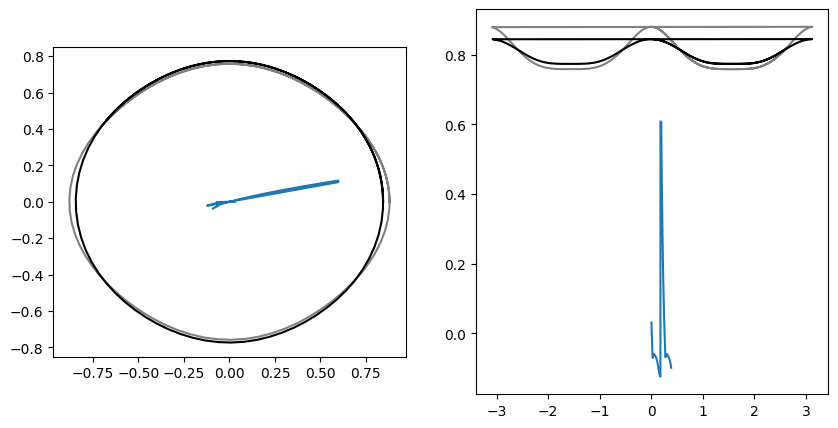

In [62]:
i = 15

J_orig = sample_batch[:,1].to(torch.float32)
phi_orig = sample_batch[:,2].to(torch.float32)

x = J_orig[i]*torch.exp(1j*phi_orig[i])
xp = xp_f(x, torch.conj(x), omega0_val)

x = torch.stack((J_orig, phi_orig), axis=-1).to(device)
mu, logvar = model.encoder(x)

J = mu[:, :, :config['dim']]
phi_dot = mu[:, :, config['dim']:]
phi = model.integrate_phi_dot(torch.unsqueeze(x[:, 0, config['dim']:], 1), phi_dot)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aa_plot(axs, J_orig[i], phi_orig[i], label='original', c='grey')
aa_plot(axs, torch.abs(xp), torch.angle(xp), label='original', c='black')
aa_plot(axs, J[i].detach().cpu(), phi[i].detach().cpu(), label='predicted')
axs[0].set_aspect('equal')

In [11]:
running_loss = []
running_mse = []
running_kl = []
running_aa = []

model.train()

pbar = tqdm(range(config['epochs']))
for epoch in pbar:
	total_loss, total_mse, total_kl, total_aa = 0.0, 0.0, 0.0, 0.0
	for batch_idx, x in enumerate(train_loader):
		optimizer.zero_grad()

		J_orig = x[:,1].to(torch.float32)
		phi_orig = x[:,2].to(torch.float32)
		x = torch.stack((J_orig, phi_orig), axis=-1).to(device)
		
		recon, mu, logvar, phi, J = model(x)
		loss, mse_loss, kl_loss, aa_loss = loss_fn(recon, mu, logvar, phi, x, config)

		total_loss += loss
		total_mse += mse_loss
		total_kl += kl_loss
		total_aa += aa_loss

		loss.backward()
		optimizer.step()

	pbar.set_postfix_str(f"Loss: {total_loss/len(train_loader):.2f}")
	running_loss.append(total_loss.item() / len(train_loader))
	running_mse.append(total_mse.item() / len(train_loader))
	running_kl.append(total_kl.item() / len(train_loader))
	running_aa.append(total_aa.item() / len(train_loader))

torch.save(model.state_dict(), checkpoint_dir / 'ckpt.pt')
with open(checkpoint_dir/'config.json', 'w') as f:
	json.dump(config, f)

100%|██████████| 10/10 [00:00<00:00, 32.75it/s, Loss: 2.09]


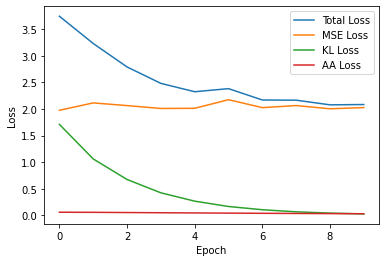

In [12]:
plt.plot(running_loss, label='Total Loss')
plt.plot(running_mse, label='MSE Loss')
plt.plot(np.array(running_kl)*config['kl_weight'], label='KL Loss')
plt.plot(np.array(running_aa)*config['aa_weight'], label='AA Loss')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

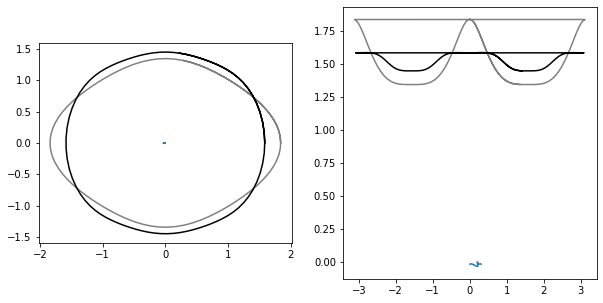

In [13]:
model.eval()
i = 31

J_orig = sample_batch[:,1].to(torch.float32)
phi_orig = sample_batch[:,2].to(torch.float32)

x = J_orig[i]*torch.exp(1j*phi_orig[i])
xp = xp_f(x, torch.conj(x), omega0_val)

x = torch.stack((J_orig, phi_orig), axis=-1).to(device)
mu, logvar = model.encoder(x)

J = mu[:, :, :config['dim']]
phi_dot = mu[:, :, config['dim']:]
phi = model.integrate_phi_dot(torch.unsqueeze(x[:, 0, config['dim']:], 1), phi_dot)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aa_plot(axs, J_orig[i], phi_orig[i], label='original', c='grey')
aa_plot(axs, torch.abs(xp), torch.angle(xp), label='original', c='black')
aa_plot(axs, J[i].detach().cpu(), phi[i].detach().cpu(), label='predicted')
axs[0].set_aspect('equal')

In [14]:
x.shape, torch.unsqueeze(x[:, 0, config['dim']:], 1).shape, phi_dot.shape

(torch.Size([32, 100, 2]), torch.Size([32, 1, 1]), torch.Size([32, 100, 1]))

In [15]:
J = test_dset[:, 1].to(torch.float32)
phi = test_dset[:, 2].to(torch.float32)

x = torch.stack((J, phi), axis=-1).to(device)
mu, logvar = model.encoder(x)

inputs = x.reshape((-1, 2)).detach().cpu()

outputs = mu.reshape((-1, 2)).detach().cpu()

In [16]:
default_pysr_params = dict(
	populations=30,
	procs=4,
	model_selection="best",
)

# Learn equations
pysr_model = PySRRegressor(
	niterations=30,
	binary_operators=["plus", "mult"],
	unary_operators=["cos", "exp", "sin", "cot"],
	**default_pysr_params
)

pysr_model.fit(inputs, outputs)

NameError: name 'PySRRegressor' is not defined

In [ ]:
print("J=")
display(pysr_model.sympy()[0])
print("phi=")
display(pysr_model.sympy()[1])

J=


exp(exp((x0 + x1)*1.5270514)*(-2.3637521))*exp(exp(sin(cos(x0))))*(-2.0105867e-6)*x1 + 0.5690669

phi=


cos(exp(x1*(-0.4148508))*(-0.0020984872)*(x0 + cos(exp(cos(x0)) + cos(x1)))*4.4341955)*(-0.13639428)

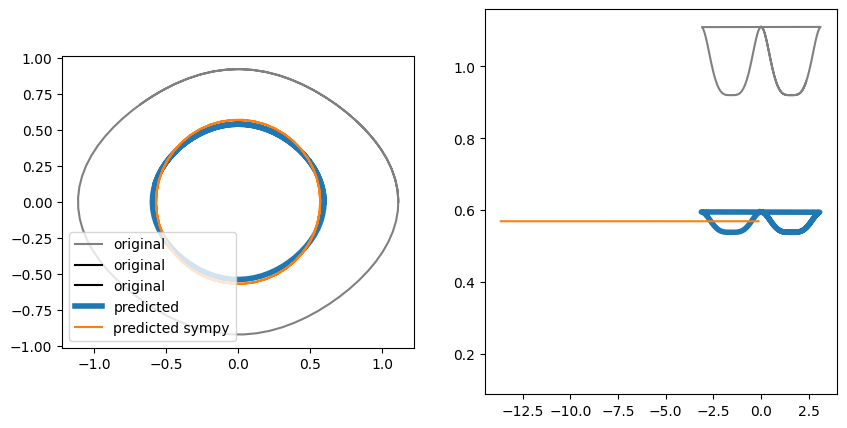

In [ ]:

x = torch.stack((J_orig[i], phi_orig[i]), axis=-1)
xp = torch.tensor(pysr_model.predict(x))
J_new = xp[:, 0]
phi_dot_new = xp[:, 1]

# (torch.Size([32, 100, 2]), torch.Size([32, 1, 1]), torch.Size([32, 100, 1]))
phi_new = model.integrate_phi_dot(torch.unsqueeze(x.unsqueeze(0)[:, 0, config['dim']:], 1), phi_dot_new.unsqueeze(0).unsqueeze(-1))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aa_plot(axs, J_orig[i], phi_orig[i], label='original', c='grey')
aa_plot(axs, torch.abs(xp), torch.angle(xp), label='original', c='black')
aa_plot(axs, J[i].detach().cpu(), phi[i].detach().cpu(), label='predicted', linewidth=4)
aa_plot(axs, J_new, phi_new[0,:,0], label='predicted sympy')
axs[0].set_aspect('equal')
axs[0].legend()